In [1]:
# %pip install hyperopt, pathos, plotly, gym-mtsim
# %pip install 

In [2]:
# # which version of pandas do I have
# # import pandas as pd
# # print(pd.__version__)
# # install version 2.0.3
# # %pip install pandas==2.0.3
# import pandas as pd
# print(pd.__version__)

In [3]:
from tqdm import tqdm
import random
import sys
import MetaTrader5 as mt5


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym
import quantstats as qs
import pytz
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_TRAIN, FOREX_DATA_PATH_TEST, FOREX_DATA_PATH


from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback
import torch
from hyperopt import hp
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
import fx


c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-unhedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-unhedge-v0 alr

In [4]:
import pickle
# unpack the pickle file and load the data that is in symbols_forex.pkl
with open('C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_forex.pkl', 'rb') as f:
    symbols = pickle.load(f)
# convert symbols to a pd.dataframe
symbols[1]['EURUSD']

,Open,Close,Low,High,Volume
Time,,,,,
2020-03-31 00:00:00+00:00,1.10414,1.10467,1.10254,1.10467,122
2020-03-31 00:15:00+00:00,1.10422,1.10293,1.10236,1.10433,104
2020-03-31 00:30:00+00:00,1.10292,1.10473,1.10236,1.10537,390
2020-03-31 00:45:00+00:00,1.10480,1.10405,1.10390,1.10531,317
2020-03-31 01:00:00+00:00,1.10415,1.10495,1.10415,1.10501,721
...,...,...,...,...,...
2024-04-10 23:00:00+00:00,1.07436,1.07438,1.07426,1.07440,175
2024-04-10 23:15:00+00:00,1.07438,1.07445,1.07437,1.07454,103
2024-04-10 23:30:00+00:00,1.07445,1.07414,1.07414,1.07445,140


In [5]:

split = int(len(symbols[1]['EURUSD']) * 0.95)
training_times = symbols[1]['EURUSD'].iloc[:split, :].index
testing_length = len(symbols[1]['EURUSD'].iloc[split:, :].index)
testing_length

5022

In [6]:
# name = 'FOREX_EURUSD_RENKO'
# # base_dir = os.path.dirname(os.path.abspath(__file__))
# path = "C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading/datasets/data/renko_full_data_50.csv"
# # path = os.path.join(base_dir, '.csv')
# pre_FOREX_EURUSD_RENKO = pd.read_csv(path, parse_dates=True, index_col='datetime')
# FOREX_EURUSD_RENKO = fx.add_cols(pre_FOREX_EURUSD_RENKO, 4, 4, bbw_period=20)

In [7]:
# # drop na rows
# FOREX_EURUSD_RENKO.dropna(inplace=True)
# FOREX_EURUSD_RENKO

In [8]:
# # plot the close price over time
# plt.figure(figsize=(14, 7))
# plt.plot(FOREX_EURUSD_RENKO.close, label='close')
# plt.legend()
# plt.show()


In [9]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()

In [10]:
# # find the max date for FOREX_EURUSD_RENKO
# max_date = FOREX_EURUSD_RENKO.index.max()
# # get the month of the max date
# max_date_month = max_date.month
# second_to_last_month = max_date_month - 1
# # find the row index for the last day of the second to last month
# second_to_last_month_day = FOREX_EURUSD_RENKO[FOREX_EURUSD_RENKO.index.month == second_to_last_month].index.max()
# split = FOREX_EURUSD_RENKO.loc[:second_to_last_month_day].shape[0]

In [11]:
# different split
# split = int(len(FOREX_EURUSD_RENKO) * 0.8)
# split
# start_index = int(split)
# end_index = int(len(FOREX_EURUSD_RENKO))-((int(len(FOREX_EURUSD_RENKO))-split) % 10)
# print(f'start_index: {start_index} \nend_index: {end_index}')

In [12]:
# def my_process_data(env):
#     start = env.frame_bound[0] - env.window_size
#     end = env.frame_bound[1]
#     prices = env.df.loc[:, 'close'].to_numpy()[start:end]
#     signal_features = env.df.loc[:, ['open', 'high', 'low', 'close', 'sma', 'smoothing_sma',
#        'sma_diff', 'sma_sign', 'sma_crossover', 
#        'bollinger_width', 'awesome_oscillator', 'day_of_week_transition',
#        'news_event_5', 'secs_until_next_news_event']].to_numpy()[start:end]
#     return prices, signal_features

# class MyForexEnvFeatures(MtEnv):
#     _process_data = my_process_data

In [13]:
sim_train = MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_train = MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size=10,
    # time_points=list(symbols[1]['EURUSD'].iloc[:split, :].index),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0002, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [14]:
sim_test = MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_test = MtEnv(
    original_simulator=sim_test,
    trading_symbols=['EURUSD'],
    window_size=10,
    # time_points=list(symbols[1]['EURUSD'].iloc[split:, :].index),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0002, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [15]:
hyperparameters = {
    # it'll be one of these once the other notebook is finished
    'lr': [1e-3, 1e-4, 1e-5], # Learning rate 
    'gamma': [0.9, 0.95, 0.99], # Discount factor
    'ent_coef': [0.01, 0.05, 0.1] # Entropy coefficient
}

In [16]:
space = {
    'lr': hp.loguniform('lr', -5, -2), # Learning rate
    'gamma': hp.uniform('gamma', 0.9, 0.99), # Discount factor
    'ent_coef': hp.loguniform('ent_coef', -5, 0), # Entropy coefficient
    'learning_timesteps': hp.choice('learning_timesteps', [25, 50, 250, 500])
}

In [17]:
# # new train_test_model
# def train_test_model(params):
#     model = PPO(
#         'MlpPolicy',
#         env_train,
#         verbose=0,
#         learning_rate=params['lr'],
#         gamma=params['gamma'],
#         ent_coef=params['ent_coef']
#         # n_steps=128
#     )

#     model.learn(total_timesteps=params['learning_timesteps'], callback=ProgressBarCallback(100))

#     # test the model
#     env = env_test
#     obs = env.reset()
#     done = False
#     while not done:
#         action, _states = model.predict(obs)
#         obs, reward, done, info = env.step(action)

#     # print the performance
#     qs.extend_pandas()
#     result = env.history
#     stats = qs.stats(result['total'])
#     return -stats['sharpe']

In [18]:
# seed_ppo = 42  # random seed
# obs_ppo, info_ppo = env_train.reset(seed=seed_ppo)
# torch.manual_seed(seed_ppo)
# random.seed(seed_ppo)
# np.random.seed(seed_ppo)

# vec_env_ppo = None

# model_ppo = PPO(policy_ppo, env_train, verbose=0, lr=hyperparameters['lr'], gamma=hyperparameters['gamma'], ent_coef=hyperparameters['ent_coef'])

# print(f'model {type(model_ppo)}')
# print(f'policy {type(model_ppo.policy)}')

# # custom callback for 'progress_bar'
# model_ppo.learn(total_timesteps=total_learning_timesteps_ppo, callback=ProgressBarCallback(100))

# env_train.close()

In [19]:
# 25K learning steps takes ~ 7.5 hrs
# 100 learning steps takes ~ 16 hrs

In [20]:
# Set the random seed
seed_ppo = 42
torch.manual_seed(seed_ppo)
random.seed(seed_ppo)
np.random.seed(seed_ppo)

total_learning_timesteps_ppo = 25 * 1000 # 5000
policy_dict_ppo = PPO.policy_aliases
policy_ppo = policy_dict_ppo.get('MlpPolicy')
if policy_ppo is None:
    policy_ppo = policy_dict_ppo.get('MlpLstmPolicy')

# Initialize the PPO model
model_ppo = PPO(policy_ppo, env_train, verbose=0, learning_rate=hyperparameters['lr'][0], gamma=hyperparameters['gamma'][0], ent_coef=hyperparameters['ent_coef'][0])

# Iterate through the training and testing sets
for i in range(0, testing_length, 10):
    split += i
    # Update the training and testing environments
    env_train.time_points = list(symbols[1]['EURUSD'].iloc[:split, :].index)
    env_test.time_points = list(symbols[1]['EURUSD'].iloc[split:, :].index)

    # Train the model
    model_ppo.learn(total_timesteps=total_learning_timesteps_ppo // 10)
    # vec_env = model_ppo.get_env()

    # Evaluate the model on the testing set
    obs_test, info_test = env_test.reset()
    initial_shape = obs_test.shape
    done_test = False
    total_reward_test = 0
    while not done_test:
        action_test, _ = model_ppo.predict(obs_test)
        obs_test, reward_test, terminated_test, truncated_test, info_test = env_test.step(action_test)
        done_test = terminated_test or truncated_test
        # total_reward_test += reward_test
    
    state = env_test.render()
    print(
        f"balance: {info_test['balance']}, equity: {info_test['equity']}, margin: {info_test['margin']}\n"
        f"free_margin: {info_test['free_margin']}, margin_level: {info_test['margin_level']}\n"
        f"step_reward: {info_test['step_reward']}, profit: {state['orders'].Profit.sum()}"
    )
    

    

# Save the model after training
model_ppo.save("ppo_model.pkl")

# Load the saved model
model_ppo = PPO.load("ppo_model.pkl", env=env_train)


AttributeError: 'dict' object has no attribute 'flatten'

In [ ]:
# len(env_train.signal_features) + len(env_test.signal_features), len(env_train.signal_features), len(env_test.signal_features), len(env_test.df)

(83713, 66988, 16725, 83703)

In [ ]:
# env_test = MyForexEnv(
#     df=FOREX_EURUSD_RENKO,
#     window_size=10,
#     frame_bound=(start_index, end_index),
#     trade_fee=0.0001,
#     spread=0.0001,
#     spread_bool=False,
#     unit_side='right',
#     sma_length=4,
#     smoothing_sma=4
# )

# Random Actions

info: {'total_reward': -60.002803802490234, 'total_profit': 0.9875027290398094, 'position': <Positions.Long: 1>}


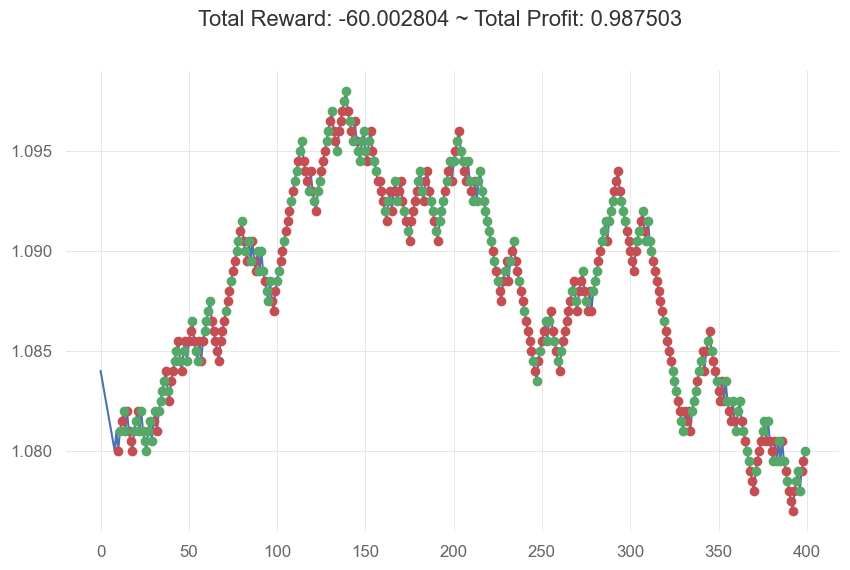

In [ ]:
# observation = env_test.reset(seed=seed_ppo)
# action_stats_rdm = {Actions.Sell: 0, Actions.Buy: 0}
# while True:
#     action_rdm = env_test.action_space.sample()
#     action_stats_rdm[Actions(action_rdm)] += 1
#     observation, reward, terminated, truncated, info = env_test.step(action_rdm)
#     done = terminated or truncated

#     # env.render()
#     if done:
#         print("info:", info)
#         print(f"action stats: {action_stats_rdm}")
#         break

# plt.cla()
# env_test.unwrapped.render_all()
# plt.show()

# Model Performance

In [ ]:
# done = False
# action_stats = {Actions.Sell: 0, Actions.Buy: 0}
# test_obs, info_ppo = env_test.reset(seed=seed_ppo)
# rows = test_obs.shape[0]

# while not done:
#     if test_obs.shape[0] != rows:
#         # print(test_obs)
#         diff = rows - test_obs.shape[0]
#         test_obs = np.concatenate([test_obs, np.zeros((diff, test_obs.shape[1]))])
#         # print(test_obs.shape)    
#     action_ppo, _states = model_ppo.predict(test_obs)
#     action_stats[Actions(action_ppo)] += 1
#     test_obs, reward_ppo, terminated, truncated, info_ppo = env_test.step(action_ppo)
#     done = terminated or truncated

#     if done:
#         break

# env_test.close()

# print("action_stats:", action_stats)
# print("info:", info_ppo)

action_stats: {<Actions.Sell: 0>: 363, <Actions.Buy: 1>: 26}
info: {'total_reward': 90.00062942504883, 'total_profit': 1.001773462105597, 'position': <Positions.Long: 1>}


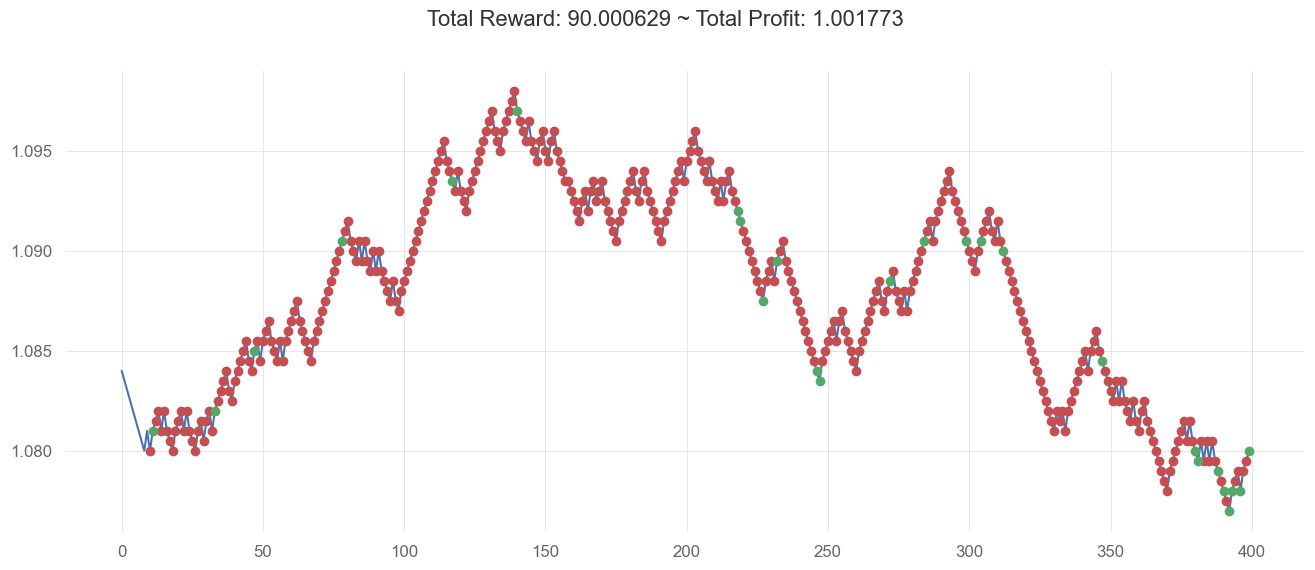

In [ ]:
# plt.figure(figsize=(16, 6))
# env_test.unwrapped.render_all()
# plt.show()

In [ ]:
# qs.extend_pandas()
# window_size = 10


# net_worth = pd.Series(env_test.unwrapped.history['total_profit'], index=FOREX_EURUSD_RENKO.index[start_index+1:end_index])
# returns = net_worth.pct_change().iloc[1:]

# qs.reports.full(returns)
# qs.reports.html(returns, output='SB3_a2c_quantstats_ppo_Billy.html')